In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Exponential Weighted Average

Given a sequence $\{\theta_t \}_{t=1,\dots, N}$ we define $$v_t = \beta\cdot v_{t-1}+(1-\beta)\cdot\theta_t \quad , \quad v_0=0$$
Then $v_t$ expresses the average over $\frac{t}{1-\beta}$ examples.   
We could also correct this by defining $$v_t^{\text{corr}} = \frac{v_t}{1-\beta ^t}$$

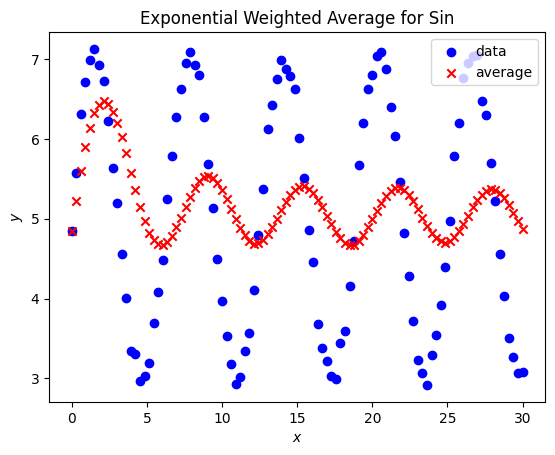

In [2]:
def generate_data(n = 100, mean = 0, sigma = 0.1):
    x = np.linspace(0, 30, n)
    y = 2*np.sin(x) + 5 + np.random.normal(mean, sigma, n)
    
    return x, y

def exponential_weighted_average(data, beta = 0.95):
    v = np.zeros(data.size+1)
    # define the first element as v_0 = 0
    v[0] = 0

    for i in range(1, v.size):
        v[i] = beta*v[i-1] + (1- beta)*data[i-1]
    
    # use also the bias correction 1/(1-beta^t)
    for i in range(1, v.size):
        v[i]/=(1-beta**i)

    return v

def plot_data_average():
    x, y = generate_data()
    v = exponential_weighted_average(y)
    fig, ax = plt.subplots()

    ax.scatter(x, y, c = 'b', marker= 'o', label = 'data')
    ax.scatter(x, v[1:], c = 'r', marker= 'x', label = 'average')

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$') 
    ax.set_title('Exponential Weighted Average for Sin')
    ax.legend()

    return ax

ax = plot_data_average()
plt.show()

# Usage of Exponential Weighted Average for speeding Gradient Descent

## Gradient Descent with momentum
Normal gradient Descent
$$
\theta \,\, \leftarrow \, \, \theta - \alpha \cdot \nabla_{\theta} J
$$
Idea: use an exponential weighted average on the parameters $\vec{\theta}$ to average out the highly oscillating directions. $d\theta \equiv \nabla_{\theta}J$
$$
\begin{align}
v_{d\theta} \,\, &\leftarrow \,\, \beta \cdot v_{d\theta} + (1-\beta)\cdot d\theta \\
v_{d\theta}^{\text{corr}} \,\, & = \,\, \frac{v_{d\theta}}{1-\beta^t} \\
\theta \,\, & \leftarrow \,\, \theta -\alpha \cdot v_{d\theta}^{\text{corr}}  
\end{align}
$$

## RMSProp
Idea: Calculate an exponential weighted average for $d\theta^2$ and use this to update parameters as
$$
\begin{align}
s_{d\theta} \,\, &\leftarrow \,\, \beta \cdot s_{d\theta} + (1-\beta)\cdot d\theta^2 \\
s_{d\theta}^{\text{corr}} \,\, & = \,\, \frac{s_{d\theta}}{1-\beta^t} \\
\theta \,\, & \leftarrow \,\, \theta -\alpha \cdot \frac{d\theta}{\sqrt{s_{d\theta} ^{\text{corr}}+\epsilon }}  \quad , \quad  \epsilon=10^{-8}
\end{align}
$$
so to move fast in the directions where $d\theta^2$ is small

## Adam
Idea: Combine both GDM and RMSProp

$$
\begin{align}
v_{d\theta} \,\, &\leftarrow \,\, \beta_1 \cdot v_{d\theta} + (1-\beta_1)\cdot d\theta \\
v_{d\theta}^{\text{corr}} \,\, & = \,\, \frac{v_{d\theta}}{1-\beta_1^t} \\

s_{d\theta} \,\, &\leftarrow \,\, \beta_2 \cdot s_{d\theta} + (1-\beta_2)\cdot d\theta^2 \\
s_{d\theta}^{\text{corr}} \,\, & = \,\, \frac{s_{d\theta}}{1-\beta_2^t} \\
\theta \,\, & \leftarrow \,\, \theta -\alpha \cdot \frac{v_{d\theta}^{\text{corr}}}{\sqrt{s_{d\theta} ^{\text{corr}}+\epsilon }}  \quad , \quad  \epsilon=10^{-8}
\end{align}
$$

We will use Adam to find the minimum of the Beales function (2-dim).

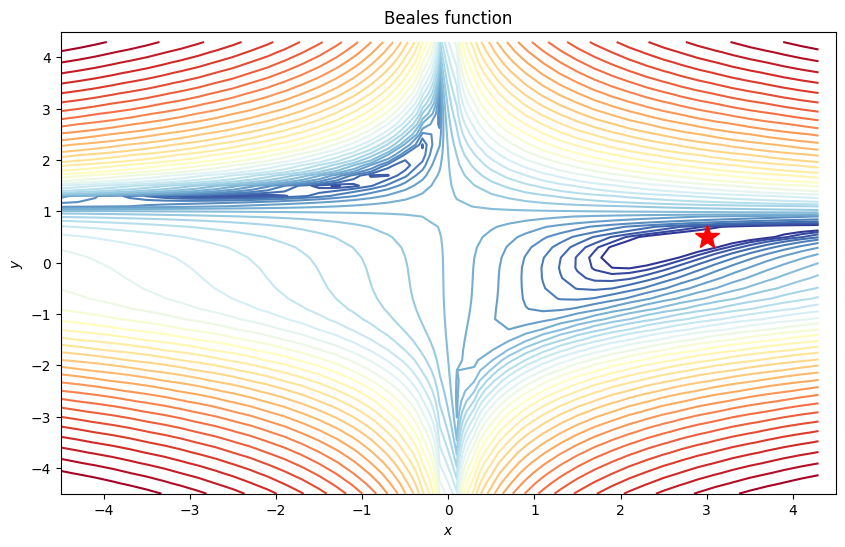

In [3]:
# definition of Beales function and contour plot

def beales_function(x, y):
    return np.square(1.5-x+x*y)+np.square(2.25-x+x*y*y)+np.square(2.625-x+x*y**3)

def grad_beales_function(point):
    x, y = point
    grad_x = 2*(1.5-x+x*y)*(-1+y)+2*(2.25-x+x*y**2)*(-1+y**2)+2*(2.625-x+x*y**3)*(-1+y**3)
    grad_y = 2*(1.5-x+x*y)*x+4*(2.25-x+x*y**2)*x*y+6*(2.625-x+x*y**3)*x*y**2
    return grad_x, grad_y

def contour_beales_function(a = -4.5, b = 4.5, step = 0.2, color = 'RdYlBu_r'):
    #plot beales function
    x, y = np.meshgrid(np.arange(a, b, step), np.arange(a, b, step))
    fig, ax = plt.subplots(figsize=(10, 6))
    z = beales_function(x, y)
    ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap = color)
    # plot the global minimum
    ax.plot(3, 0.5, 'r*', markersize=18)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    ax.set_xlim((-4.5, 4.5))
    ax.set_ylim((-4.5, 4.5))
    
    return fig, ax

fig, ax = contour_beales_function()
ax.set_title('Beales function')
plt.show()

In [4]:
def gradient_descent(init_point, gradient_function, n_epochs = 1000, alpha = 0.001):
    
    point = np.array(init_point)
    trajectory_points = np.zeros((n_epochs+1, 2))
    trajectory_points[0] = point

    # loop through the epochs
    for i in range(1, n_epochs+1):

        # calculate the gradient at the point
        gradient = np.array(gradient_function(point))

        # update the point
        point = point - alpha*gradient
        
        # store the point
        trajectory_points[i] = point
    
    return trajectory_points


def gd_momentum(init_point, gradient_function, n_epochs = 1000, alpha = 0.001, beta = 0.9):
    
    point = np.array(init_point)
    trajectory_points = np.zeros((n_epochs+1, 2))
    trajectory_points[0] = point
    
    # initialize v
    v = np.zeros(2)

    # loop through the epochs
    for i in range(1, n_epochs+1):

        # calculate the gradient at the point
        gradient = np.array(gradient_function(point))

        v = beta*v + (1-beta)*gradient
        v_corr = v/(1-beta**i)

        # update the point
        point = point - alpha*v_corr
        
        # store the point
        trajectory_points[i] = point
    
    return trajectory_points

def rms_prop(init_point, gradient_function, n_epochs = 1000, alpha = 0.001, beta = 0.99, epsilon = 10**-8):
    
    point = np.array(init_point)
    trajectory_points = np.zeros((n_epochs+1, 2))
    trajectory_points[0] = point
    
    # initialize s
    s = np.zeros(2)

    # loop through the epochs
    for i in range(1, n_epochs+1):

        # calculate the gradient at the point
        gradient = np.array(gradient_function(point))

        s = beta*s + (1-beta)*gradient**2
        s_corr = s/(1-beta**i)

        # update the point
        point = point - alpha*gradient/np.sqrt(s_corr+epsilon)
        
        # store the point
        trajectory_points[i] = point
    
    return trajectory_points

In [5]:
def adam(init_point, gradient_function, n_epochs = 1000, alpha = 0.001, beta1 = 0.9, beta2 = 0.99, epsilon = 10**-8):
    
    point = np.array(init_point)
    trajectory_points = np.zeros((n_epochs+1, 2))
    trajectory_points[0] = init_point
    
    # initialize v and s
    v = np.zeros(2)
    s = np.zeros(2)

    # loop through the epochs
    for i in range(1, n_epochs+1):

        # calculate the gradient at the point
        gradient = np.array(gradient_function(point))

        v = beta1*v + (1-beta1)*gradient
        v_corr = v/(1-beta1**i)

        s = beta2*s +(1-beta2)*gradient**2
        s_corr = s/(1-beta2**i)

        # update the point
        point = point - alpha*(v_corr/np.sqrt(s_corr+epsilon))
        
        # store the point
        trajectory_points[i] = point
    
    return trajectory_points

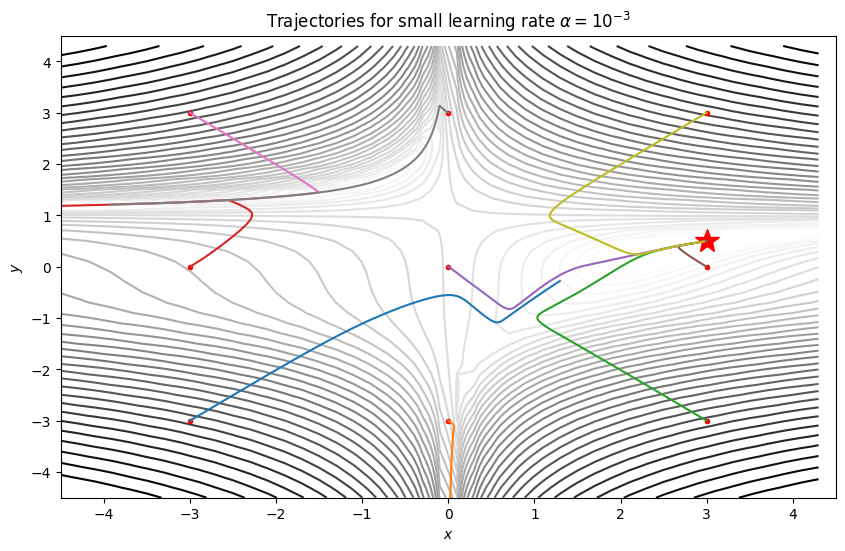

In [6]:
# examine grid points in -3,3
n = 3
x = np.linspace(-3, 3, n)
y = np.linspace(-3, 3, n)
grid = np.meshgrid(x, y)
grid_points = np.concat( (grid[0].reshape(-1, 1), grid[1].reshape(-1, 1)) , axis = 1)
fig, ax = contour_beales_function(color= 'Greys')

for point in grid_points:

    trajectory_adam = adam(point, grad_beales_function, n_epochs=5000, alpha=0.001)
    
    ax.plot(point[0], point[1], 'ro', markersize=3)
    ax.plot(trajectory_adam[:, 0], trajectory_adam[:, 1])

ax.set_title('Trajectories for small learning rate $\\alpha=10^{-3}$')
plt.show()

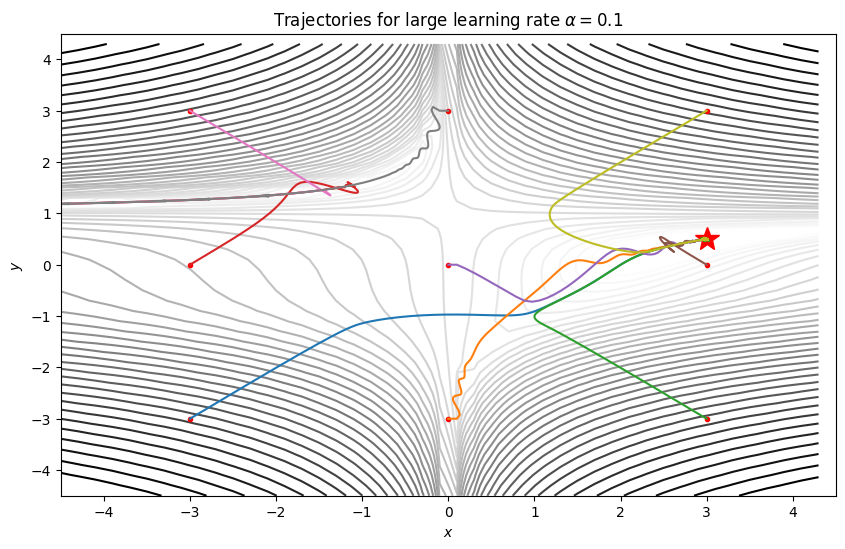

In [7]:
# examine grid points in -3,3
n = 3
x = np.linspace(-3, 3, n)
y = np.linspace(-3, 3, n)
grid = np.meshgrid(x, y)
grid_points = np.concat( (grid[0].reshape(-1, 1), grid[1].reshape(-1, 1)) , axis = 1)
fig, ax = contour_beales_function(color= 'Greys')

for point in grid_points:

    trajectory_adam = adam(point, grad_beales_function, n_epochs=5000, alpha=0.1)
    
    ax.plot(point[0], point[1], 'ro', markersize=3)
    ax.plot(trajectory_adam[:, 0], trajectory_adam[:, 1])

ax.set_title('Trajectories for large learning rate $\\alpha=0.1$')
plt.show()

# Automatic differentiation
Use tensorflow's autodiff and gradient tape to analytically differentiate the cost function.